In [5]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import tensorflow as tf

data_dir = "../data/"
train_vals_df = pd.read_csv(os.path.join(data_dir, "train_values.csv"))
train_labels_df = pd.read_csv(os.path.join(data_dir, "train_labels.csv"))

# get categorical data
X1 = train_vals_df[["geo_level_1_id", "geo_level_2_id", "position", "foundation_type", "roof_type", "ground_floor_type", "other_floor_type", "plan_configuration", "legal_ownership_status"]].to_numpy()

enc = OrdinalEncoder()
enc.fit(X1)
X1 = enc.transform(X1)

## get numerical data
df = train_vals_df[[
'count_floors_pre_eq',
'age',
'area_percentage',
'height_percentage']]

# normalize numerical data
min_max_scaler = preprocessing.MinMaxScaler()
X2 = min_max_scaler.fit_transform(df.values)


# get labels

y = train_labels_df["damage_grade"].to_numpy()
y = np.eye(3)[y-1]

X = np.concatenate((X1,X2), axis = 1)
# X = np.asarray(X).astype('float32')

In [6]:
train_vals_df = pd.read_csv(os.path.join(data_dir, "train_values.csv"))
train_vals_df.columns
# train_labels_df = pd.read_csv(os.path.join(data_dir, "train_labels.csv"))

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_i

In [207]:
np.unique(train_vals_df["legal_ownership_status"])

array(['a', 'r', 'v', 'w'], dtype=object)

## Train val test split
### X1 is categorical data and X2 is numerical data

In [21]:
rng = np.random.RandomState(7)
perm = rng.permutation(range(len(X)))
X_rand = X[perm]
y_rand = y[perm]

trainIdx = int(.7*len(X))
valIdx = int(.85*len(X))
X_train = X[:trainIdx]
y_train = y[:trainIdx]
X_val = X[trainIdx:valIdx]
y_val = y[trainIdx:valIdx]
X_test = X[valIdx:]
y_test = y[valIdx:]

In [26]:
y_test.shape

(39091, 3)

In [8]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## Create model that embeds categorical data (each location separately)

In [211]:
## This model achieves .7037 micro F1
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Embedding

# checkpoint_filepath = '/tmp/saved_models'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_categorical_accuracy',
#     mode='max',
#     save_best_only=True)

# ## Creating the layers
# batch_size = 100
# input = Input(shape=(8,)) 
# embedding0 = Embedding(31, 2)(input[:,0]) # geo id 1
# embedding1 = Embedding(1428, 2)(input[:,1]) # geo id 2
# embedding2 = Embedding(4, 2)(input[:,2]) # position
# embedding3 = Embedding(5, 2)(input[:,3]) # foundation type
# Layer_1 = Dense(10, activation="relu")(tf.concat([embedding0,embedding1,embedding2,embedding3,input[:,4:]], 1))
# Layer_2 = Dense(5, activation="relu")(Layer_1)
# output_layer= Dense(3, activation="softmax")(Layer_2)

# model = tf.keras.Model(inputs=input, outputs=output_layer, name="emb_model")
# opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer=opt, loss='CategoricalCrossentropy', metrics=['CategoricalAccuracy'])
# history = model.fit(X_train, y_train, epochs=25, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Embedding

checkpoint_filepath = '/tmp/saved_models'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

## Creating the layers
batch_size = 512
input = Input(shape=(13,)) 
embedding0 = Embedding(31, 2)(input[:,0]) # geo id 1
embedding1 = Embedding(1428, 2)(input[:,1]) # geo id 2
embedding2 = Embedding(4, 2)(input[:,2]) # position
embedding3 = Embedding(5, 2)(input[:,3]) # foundation type
embedding4 = Embedding(3, 2)(input[:,4]) # roof type
# embedding5 = Embedding(5, 2)(input[:,5]) # ground floor type
# embedding6 = Embedding(4, 2)(input[:,6]) # other floor type
# embedding7 = Embedding(10, 3)(input[:,7]) # plan configuration
# embedding8 = Embedding(4, 2)(input[:,8]) # legal ownership status
# Layer_1 = Dense(20, activation="relu")(tf.concat([embedding0,embedding1,embedding2,embedding3,embedding4,embedding5,embedding6, embedding7, embedding8, input[:,9:]], 1))
Layer_1 = Dense(20, activation="relu")(tf.concat([embedding0,embedding1,embedding2,embedding3,embedding4, input[:,5:]], 1))
Layer_2 = Dense(15, activation="relu")(Layer_1)
Layer_3 = Dense(10, activation="relu")(Layer_2)
output_layer= Dense(3, activation="softmax")(Layer_3)

model = tf.keras.Model(inputs=input, outputs=output_layer, name="emb_model")
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='CategoricalCrossentropy', metrics=['CategoricalAccuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
357/357 [==============================] - 1s 2ms/step - loss: 0.9196 - categorical_accuracy: 0.5698 - val_loss: 0.9030 - val_categorical_accuracy: 0.5672
Epoch 2/100
357/357 [==============================] - 0s 1ms/step - loss: 0.8971 - categorical_accuracy: 0.5680 - val_loss: 0.8798 - val_categorical_accuracy: 0.5672
Epoch 3/100
357/357 [==============================] - 0s 1ms/step - loss: 0.8712 - categorical_accuracy: 0.5689 - val_loss: 0.8489 - val_categorical_accuracy: 0.5672
Epoch 4/100
357/357 [==============================] - 0s 1ms/step - loss: 0.8361 - categorical_accuracy: 0.5719 - val_loss: 0.7967 - val_categorical_accuracy: 0.5923
Epoch 5/100
357/357 [==============================] - 0s 1ms/step - loss: 0.7812 - categorical_accuracy: 0.6119 - val_loss: 0.7353 - val_categorical_accuracy: 0.6572
Epoch 6/100
357/357 [==============================] - 0s 1ms/step - loss: 0.7245 - categorical_accuracy: 0.6617 - val_loss: 0.7033 - val_categorical_accuracy: 0.673

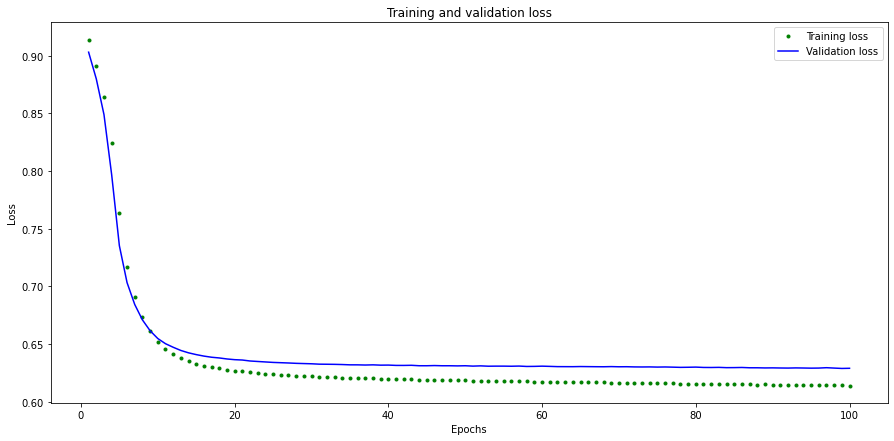

[15.0, 7.0]


In [15]:
import matplotlib.pyplot as plt

# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (15,7)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

In [28]:
predictions = model.predict(X_val)
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
predictions = model.predict(X_val)
y_pred = []
y_true = []
for i,row in enumerate(predictions):
  y_pred.append(np.argmax(row))
  y_true.append(np.argmax(y_val[i]))

f1_score(y_true, y_pred, average = 'micro')

0.7108979278587874

In [29]:
X_test.shape

(39091, 13)

In [30]:
y_test.shape

(39091, 3)

In [31]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
predictions = model.predict(X_test)
y_pred = []
y_true = []
for i,row in enumerate(predictions):
  y_pred.append(np.argmax(row))
  y_true.append(np.argmax(y_test[i]))

f1_score(y_true, y_pred, average = 'micro')

0.7093960246604077

In [32]:
test_vals_df = pd.read_csv("../data/test_values.csv")
# get categorical data
X1 = test_vals_df[["geo_level_1_id", "geo_level_2_id", "position", "foundation_type", "roof_type", "ground_floor_type", "other_floor_type", "plan_configuration", "legal_ownership_status"]].to_numpy()
enc = OrdinalEncoder()
enc.fit(X1)
X1 = enc.transform(X1)
## get numerical data
df = test_vals_df[[
'count_floors_pre_eq',
'age',
'area_percentage',
'height_percentage']]

# normalize numerical data
min_max_scaler = preprocessing.MinMaxScaler()
X2 = min_max_scaler.fit_transform(df.values)



X_test = np.concatenate((X1,X2), axis = 1)

predictions = model.predict(X_test)
y_pred = []
for i,row in enumerate(predictions):
  y_pred.append(np.argmax(row) + 1)


submission = pd.DataFrame()
submission["building_id"] = test_vals_df["building_id"]
submission["damage_grade"] = y_pred
submission
submission.to_csv("embedding_model2.csv", index=False)